* Romain Pous, 2021
* Kalman filtering applied to argo datas bias

## 1) Introduction

The identification technique used during here is Kalman filtering.  This filter allows to correct observations, using statistical data such as the variance of a variable. By observing at each cycle (every 10 days) for a given depth the temperature and salinity obtained by a profiler, we are able thanks to the Kalman filter to bring a correction on the temperature and salinity. The advantage of this filtering method is that it also allows to estimate unobserved, partially observed or observed variables thanks to the observation of another variable. In our case, the correlation between temperature and salinity allows us to analyze and correct for salinity through the observation of temperature, which, by the way, is not biased. Thus, variables linked by relationships will be estimated, analyzed and corrected by the observation of other variables. So, in theory, we can try to estimate the bias in salinity by observing salinity and temperature, because it will be related to them. We find a similar method used by other researchers in Brest (Cabanes et al, 2016)

From statistical data and a computer model, we will estimate our variables on one side. On the other hand, we have our raw data observed by the ARGO floats. We then proceed to an analysis step that will synthesize the modeling and the observation. A new value comes out of it, which we will consider as being the "true" value of our variable.
This value will then be used by the model to make an estimate ("forecast") at the next time step, which will itself be "mixed" with the observed data to give a new value. Let's take a simple example with the temperature. We apply our computer model which is derived from statistical data (expectation, variance etc) and physical equations to our temperature at the previous time step. The value obtained, which is the estimated value of the temperature, is mixed with the observed value of the temperature to give the analyzed value considered as the real value. We can then estimate the temperature at the next time step from this value and start the process again. 

### Calibration of the Kalman Filter

To calibrate the Kalman filter, we need to define what is called the Kalman gain. In order to determine the weight, the confidence brought to the observation or to the modeling, we use the Kalman gain expressed in the form of a matrix K. It gathers parameters on which we can influence. We find for example a matrix R, matrix mainly of measurement errors. The Kalman gain is expressed as a function of the P matrix which is a covariance matrix. This matrix is the key to the resolution of the problem. It is the matrix that allows us to model the confidence we have in our estimation results, through the variances of the variables (temperature, salinity, etc.), but also the covariances between our variables (such as the covariance between T and S). It is therefore the presence of the covariance between T and S in this matrix that allows us to bring this additional missing information to the estimation of our drift in salinity. 
We will therefore use this assimilation tool by formulating the problem as follows: we have 2 observed variables which are temperature and salinity and we will estimate 5 variables. These variables will be first the temperature and salinity, but also the temperature bias, the salinity bias and the slope (a) of the salinity drift. There are several reasons for this formulation. The salinity bias will be estimated over time. However, this bias is a drift. Thus, it evolves over time in a linear manner and can therefore be formulated as bs(t)=a*t+b . This slope "a" is assumed to be constant and would theoretically be worth 0.004 PSU/year. We will therefore concentrate on this variable which is constant. The estimation should be easier, the value to estimate at each time step being the same. We also want to estimate the temperature bias in order to check the good functioning of the filter because it is supposed to be zero. It represents a kind of safeguard in our experiments. We propose to expose hereafter with a little more detail the structure of the Kalman filter that we implement.


Kalman filtering is a process that requires an initialization as well as an adjustment of the parameters that compose it. Here is what has been done in the context of this internship:
The state vector that we will estimate, the x vector, will be composed of 5 variables: temperature, salinity, temperature bias, salinity bias and the slope of the bias.
The observation vector y is composed of the temperature and salinity for a given depth and for a given profiler
The operator matrix H must satisfy the following observation equations:
Tobs = T + bt
Sobs = S + bs
Indeed, when we obtain temperature and salinity data, thus observed data, they are actually the sum of the "real" temperature and salinity with their respective bias. We thus go back through this matrix to the bias in salinity. It is this matrix that extracts the bias of the observation.
The matrix H can thus be written 1 0 1 0 0,0 1 0 1 0 because it makes the link between the state vector x composed of 5 variables and the observation vector y composed of 2 variables.
The covariance matrix P is an almost diagonal matrix, with the covariance between T and S as an element in 0.1 and 1.0. Indeed, below the ocean surface mixing layer, temperature and salinity have a strong correlation.


The Q matrix is used to correct the model whose errors are assumed to be small compared to the variances of the P matrix. It is composed of the variances of the differences between the observations of T at time step i and i+1 and the variances of the differences between the observations of S at time step i and i+1. The other variances are chosen semi-arbitrarily, i.e. we will use the measurement errors as for the P matrix but divided by 10.
The R matrix is a diagonal matrix with the temperature and salinity measurement errors on the diagonal. It is therefore a 2*2 matrix with measurement errors from the literature.

## 2) Roadmap

a. We begin by combining the data from a multi-year ARGO profiler into a single file.

b. We prepare all our auxiliary functions. We use afterwards the BLUE function for the analysis step of our Kalman filtering and we prepare next to it the statistical data that will be used in our code. Storage and plot functions are also proposed. 

c. From the initialization function which creates most of the matrices of our problem, we build our Kalman function.

## 3) Code

In [7]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import xarray as xr
import numpy.ma as ma
from math import *
import matplotlib.pyplot as plt
%matplotlib inline

params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}

plt.rcParams.update(params)

#### Merged Years

In [6]:
def selec_one_argo_one_year_all_runs(station,year):
    """File selection function. It selects all datas for a profiler from one year.
        - station is the station identifier,
        - year is the year selected."""
    #first run first
    path=path_occiput_obs+'/OBS-enact_y'+str(year)
    file1=path+'/ORCA025.L75-OCCITENS.001_y'+str(year)+'_enact_fdbk.nc'
    ds1=xr.open_dataset(file1,decode_times=False)
    stations=ds1.STATION_IDENTIFIER
    ind=np.where(stations==station)
    ds1_argo_selec=ds1.sel(N_OBS=ind[0]) 

    return ds1_argo_selec
    
    
def selec_one_argo_years_all_runs(station,year1,year2):
    """File selection function. It selects all datas for a profiler for 3 years.
        - station is the station identifier,
        - years are the years selected."""
    #first year first
    ds_concat=selec_one_argo_one_year_all_runs(station,year1)
    #loop on the other years
    for year in np.arange(year1+1,year2+1):
        ds=selec_one_argo_one_year_all_runs(station,year)
        ds_concat=xr.concat([ds_concat,ds],dim='N_OBS')

    #write on disk
    stat=str(station.values)
    str_stat=stat[2:10]
    ds_concat.to_netcdf('/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles'+str(str_stat)+'_y'+str(year1)+'-'+str(year2)+'_r1-50.nc')


In [8]:
#test for one year
#the path where all data are stored
path_occiput_obs='/mnt/pousr/old-equipes/IGE/meom/MODEL_SET/ORCA025.L75/ORCA025.L75-OCCITENS/OBS'
path2010=path_occiput_obs+'/OBS-enact_y2010'
one_file2010=path2010+'/ORCA025.L75-OCCITENS.001_y2010_enact_fdbk.nc'
ds_one2010=xr.open_dataset(one_file2010,decode_times=False)
stations=ds_one2010.STATION_IDENTIFIER
stat4900786=stations[4368]

In [10]:
%%time
selec_one_argo_years_all_runs(stat4900786,2010,2012)

CPU times: user 9.4 s, sys: 616 ms, total: 10 s
Wall time: 19.3 s


## Preparation code

In [12]:
#the path to the file for one run (the 1st)
one_file1='/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles19007_y2010-2012_r1-50.nc'
#opening one file
ds1=xr.open_dataset(one_file1,decode_times=False)

def blue(xf,Pf,yobs,Robs,Hobs):
    """compute the BLUE solution."""
#Opérateur d'obs fois la matrice de covariance P
    HPf=np.dot(Hobs,Pf)
#Principal membre du gain de kalman (HpfH)**T + R
    InnovM=np.dot(Hobs,np.transpose(HPf))+Robs
#Innovation y0-H*xf où xf est le x forward soit x estimé forward. L'innovation est utilisé dans le calcul du x analyse à l'instant k
    Innovation=yobs-np.dot(Hobs,xf)
#Si scalaire
    if np.shape(InnovM)[0]==1:
        Kgain=np.transpose(HPf)/InnovM
        xa=xf+np.dot(Innovation,Kgain)
        Pa=Pf-np.outer(Kgain,HPf)
#Si vecteur
    else:  
        Kgain=np.dot(np.transpose(HPf),np.linalg.inv(InnovM))
        xa=xf+np.dot(Kgain,Innovation)
        Pa=Pf-np.dot(Kgain,HPf)
    return xa,Pa

def mask_one_profile(var):
    var_mask=ma.masked_where(var>1.7990000e+04,var)
    return var_mask

L=150
l=len(ds1.JULD)
t=np.zeros(l)

T=np.zeros((L,l))
S=np.zeros((L,l))
VarTemp=np.zeros(L)
VarSal=np.zeros(L)
MeanT=np.zeros(L)
MeanS=np.zeros(L)
Cov=np.zeros((L,2,2))

DT=np.zeros((L,l-1))
DS=np.zeros((L,l-1))
VarDTemp=np.zeros(L)
VarDSal=np.zeros(L)
CovD=np.zeros((L,2,2))


Sb=np.zeros((L,l))
VarSalb=np.zeros(L)
MeanSb=np.zeros(L)
Covb=np.zeros((L,2,2))

DSb=np.zeros((L,l-1))
VarDSalb=np.zeros(L)
CovDb=np.zeros((L,2,2))

def Preparation_Kalman(n,ds1,a):
    """Calculate variance and other statistical quantities for Kalman filtering.
    Input : -n is the indice of depth
    -ds1 is the dataset of our ARGO profiler
    -a is the salinity slope bias
    Outpout: -statistical quantities"""
    #opening one file
    ds1=xr.open_dataset(one_file1,decode_times=False)
    for i in range(l-1):
        t[i]=ds1.JULD[i]-21915
        one_profile_temp_obs_mask1=mask_one_profile(ds1.POTM_OBS[i][n])
        one_profile_salt_obs_mask1=mask_one_profile(ds1.PSAL_OBS[i][n])
        T[n][i]=one_profile_temp_obs_mask1
        S[n][i]=one_profile_salt_obs_mask1
    
        DT[n][i]=abs(mask_one_profile(ds1.POTM_OBS[i][n])-mask_one_profile(ds1.POTM_OBS[i+1][n]))
        DS[n][i]=abs(mask_one_profile(ds1.PSAL_OBS[i][n])-mask_one_profile(ds1.PSAL_OBS[i+1][n]))
    
        one_profile_salt_obs_mask2=mask_one_profile(ds1.PSAL_OBS[i][n]+a*t[i])
        Sb[n][i]=one_profile_salt_obs_mask2
        DSb[n][i]=abs(mask_one_profile(ds1.PSAL_OBS[i][n]+a*t[i])-mask_one_profile(ds1.PSAL_OBS[i+1][n]+a*t[i]))

    one_profile_temp_obs_mask1=mask_one_profile(ds1.POTM_OBS[l-1][n])
    one_profile_salt_obs_mask1=mask_one_profile(ds1.PSAL_OBS[l-1][n])
    one_profile_salt_obs_mask2=mask_one_profile(ds1.PSAL_OBS[l-1][n]+a*t[l-1])
    T[n][l-1]=one_profile_temp_obs_mask1
    S[n][l-1]=one_profile_salt_obs_mask1
    Sb[n][l-1]=one_profile_salt_obs_mask2

    MeanT[n]=np.mean(T[n])
    MeanS[n]=np.mean(S[n])
    VarTemp[n]=np.var(T[n],ddof=1)
    VarSal[n]=np.var(S[n],ddof=1)   
    Cov[n]=np.cov(T[n],S[n])

    VarDTemp[n]=np.var(DT[n],ddof=1)
    VarDSal[n]=np.var(DS[n],ddof=1)
    CovD[n]=np.cov(DT[n],DS[n])

    MeanSb[n]=np.mean(Sb[n])
    VarSalb[n]=np.var(Sb[n],ddof=1)   
    Covb[n]=np.cov(T[n],Sb[n])

    VarDSalb[n]=np.var(DSb[n],ddof=1)
    CovDb[n]=np.cov(DT[n],DSb[n])

In [56]:
def Plot_Kalman(x,x2,a,b,c,d):
    
    
    from matplotlib import cycler
    colors = cycler('color',['#fc280f', '#5fdcff', '#f4ba26', '#85c54c', '#c6d7e0']) # colors for artists will be cycled from this list by default
    plt.rc('figure', facecolor='#222222') # facecolor is background colour
    plt.rc('axes', facecolor='#222222', edgecolor='#222222',
       axisbelow=True, grid=True, prop_cycle=colors) # "axisbelow" set axis ticks and gridlines are below all artists
    plt.rc('grid', color='#e3e3e3', linestyle='solid')
    plt.rc('xtick', direction='in', color='#e3e3e3')
    plt.rc('ytick', direction='in', color='#e3e3e3')
    plt.rc('patch', edgecolor='#e3e3e3')
    plt.rc('lines', linewidth=1.5)


    fig = plt.figure(figsize=(12, 12))  # (w,h)
    ax = plt.subplot() 

    if x=='Y' and x2=='S':
        ax.plot((ds1.JULD-21915), a,color='#00FFFF',label='Salinity from analysis', zorder=1, marker = '+')
        ax.plot((ds1.JULD-21915), b,color='#fd411e',label='Observed Salinity', zorder=1, marker = '+')
        ax.plot((ds1.JULD-21915), c, color='#c9ff27',label='Salinity biased from analysis', zorder=1, marker = '+')
        ax.plot((ds1.JULD-21915), d,color='r',label='Observed Salinity with bias', zorder=1, marker = '+')
        plt.suptitle('Salinity for a profiler biased and unbiased for 3 years ', size=30, color='#e3e3e3')
        ax.set_ylabel('Salinity [PSU]',color='#e3e3e3')
        
    elif x=='Bt' and x2=='Btb':
        ax.plot((ds1.JULD-21915), a,color='#00FFFF',label='Temperature Biais', zorder=1, marker = '+')
        ax.plot((ds1.JULD-21915), b,color='#c9ff27',label='Temperature Biais corrupted', zorder=1, marker = '+')
        plt.suptitle('Temperature Bias for a profiler biased and unbiased for 3 years ', size=30, color='#e3e3e3')
        ax.set_ylabel('Temperature [°C]',color='#e3e3e3')
        
    elif x=='Bs' and x2=='Bsb':
        ax.plot((ds1.JULD-21915), a,color='#00FFFF',label='Salinity Biais', zorder=1, marker = '+')
        ax.plot((ds1.JULD-21915), b,color='#c9ff27',label='Salinity Biais corrupted', zorder=1, marker = '+')
        plt.suptitle('Salinity Bias for a profiler biased and unbiased for 3 years ', size=30, color='#e3e3e3')
        ax.set_ylabel('Salinity [PSU]',color='#e3e3e3')
        
    elif x=='A' and x2=='Ab':
        ax.plot((ds1.JULD-21915), a,color='#00FFFF',label='Slope Salinity Biais', zorder=1, marker = '+')
        ax.plot((ds1.JULD-21915), b,color='#c9ff27',label='Slope Salinity Biais corrupted', zorder=1, marker = '+')
        plt.suptitle('Slope Salinity for a profiler biased and unbiased for 3 years ', size=30, color='#e3e3e3')
        ax.set_ylabel('Salinity per days [PSU/days]',color='#e3e3e3')
    
    elif x=='X' and x2=='T':
        ax.plot((ds1.JULD-21915), a,color='#00FFFF',label='Temperature from analysis', zorder=1, marker = '+')
        ax.plot((ds1.JULD-21915), b,color='#fd411e',label='Observed Temperature', zorder=1, marker = '+')
        ax.plot((ds1.JULD-21915), c, color='#c9ff27',label='Temperature from analysis with bias on S', zorder=1, marker = '+')
        plt.suptitle('Temperature for a profiler biased and unbiased for 3 years ', size=30, color='#e3e3e3')
        ax.set_ylabel('Temperature [°C]',color='#e3e3e3')
        
    else :
        print ('Axes dont fit with this algo')
        
    ax.legend(labelcolor='#e3e3e3',fontsize='xx-large') 
    ax.set_xlabel('Time [days]',color='#e3e3e3')
    ax.grid(True, which='both')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

In [44]:
def model(x,P,Q,p):
    M=np.identity(5+2*p)
    M[3,4]=10
    xf=np.dot(M,x)
    Pf=np.dot(np.dot(M,P),np.transpose(M))+Q
    return xf,Pf

def forecast(x,P,Q,p):
    xf,Pf=model(x,P,Q,p)
    return xf,Pf

In [18]:
def stockage(i,Pf,Pa,xa,xab,Pfb,Pab,X,Xb,Y,Yb,Bt,Btb,Bs,Bsb,A,Ab,R):
    
    X[i+1]=xa[0]
    Xb[i+1]=xab[0]
    
    Y[i+1]=xa[1]
    Yb[i+1]=xab[1]
    
    Bt[i+1]=xa[2]
    Btb[i+1]=xab[2]
    
    Bs[i+1]=xa[3]
    Bsb[i+1]=xab[3]
    
    A[i+1]=xa[4]
    Ab[i+1]=xab[4]
    
    R[2*i+2]=np.diag(Pf)
    R[2*i+3]=np.diag(Pa)
    
    return X,Xb,Y,Yb,Bt,Btb,Bs,Bsb,A,Ab,R
        

In [114]:
def initialisation2(m,p):
    """Calculate matrix for Kalman filtering.
    Input : -m is the indice of first considered depth
    -p is the number of other considered depth
    Outpout: -matrices for our Klaman filter"""
    
    #Unbiased Datas
    xf=np.array([MeanT[m],MeanS[m],0,0,0])
    yobs=np.array([T[m][0],S[m][0]])

    Q=np.identity(5+2*p)
    Pf=np.identity(5+2*p)
    Robs=np.identity(2+2*p)
    
    Hobs=np.zeros((2+2*p,5+2*p))
    Hobs[0,0]=1
    Hobs[1,1]=1
    Hobs[0,2]=1
    Hobs[1,3]=1
    
    Q[0,0]=CovD[m][0][0]
    Q[0,1]=CovD[m][0][1]
    Q[1,0]=CovD[m][1][0]
    Q[1,1]=CovD[m][1][1]
    Q[2,2]=0.0002**2
    Q[3,3]=0.001**2
    Q[4,4]=(0.001**2)/365

    Pf[0,0]=Cov[m][0][0]
    Pf[0,1]=Cov[m][0][1]
    Pf[1,0]=Cov[m][1][0]
    Pf[1,1]=Cov[m][1][1]
    Pf[2,2]=0.002**2
    Pf[3,3]=0.01**2
    Pf[4,4]=(0.01**2)/365

    Robs[0,0]=0.002**2
    Robs[1,1]=0.01**2
    
    #Biased Datas
    Qb=np.identity(5+2*p)
    Pfb=np.identity(5+2*p)

    Pfb[0,0]=Covb[m][0][0]
    Pfb[0,1]=Covb[m][0][1]
    Pfb[1,0]=Covb[m][1][0]
    Pfb[1,1]=Covb[m][1][1]
    Pfb[2,2]=0.002**2
    Pfb[3,3]=0.01**2
    Pfb[4,4]=(0.01**2)/365
    
    Qb[0,0]=CovDb[m][0][0]
    Qb[0,1]=CovDb[m][0][1]
    Qb[1,0]=CovDb[m][1][0]
    Qb[1,1]=CovDb[m][1][1]
    Qb[2,2]=0.0002**2
    Qb[3,3]=0.001**2
    Qb[4,4]=(0.001**2)/365

    xfb=np.array([MeanT[m],MeanSb[m],0,0,0])
    yobsb=np.array([T[m][0],Sb[m][0]])
    
    #stockage
    X=np.zeros(l)
    Xb=np.zeros(l)
    Y=np.zeros(l)
    Yb=np.zeros(l)
    Bt=np.zeros(l)
    Btb=np.zeros(l)
    Bs=np.zeros(l)
    Bsb=np.zeros(l)
    A=np.zeros(l)
    Ab=np.zeros(l)
    R=np.zeros((2*l,5+2*p))
    
    return xf,Pf,yobs,Robs,Hobs,xfb,Pfb,yobsb,Q,Qb,X,Xb,Y,Yb,Bt,Btb,Bs,Bsb,A,Ab,R

In [115]:
def Kalman_ARGOs2(m,ds1,p,n,a):
    
    #Preparation of matrices and bias
    Preparation_Kalman(m,ds1,a)
    xf,Pf,yobs,Robs,Hobs,xfb,Pfb,yobsb,Q,Qb,X,Xb,Y,Yb,Bt,Btb,Bs,Bsb,A,Ab,R=initialisation2(m,p)

    #Preparation for Kalman filtering for other depth levels
    for k in range(1,p+1):
        Preparation_Kalman(m+n*k,ds1,a)
    
        xf=np.append(xf,MeanT[m+n*k])
        xf=np.append(xf,MeanS[m+n*k])
        yobs=np.append(yobs,T[m+n*k][0])
        yobs=np.append(yobs,S[m+n*k][0])
    
        Q[3+2*k,3+2*k]=CovD[m+n*k][0][0]
        #Q[3+2*k,4+2*k]=CovD[m+n*k][0][1]
        #Q[4+2*k,3+2*k]=CovD[m+n*k][1][0]
        Q[4+2*k,4+2*k]=CovD[m+n*k][1][1]
        Pf[3+2*k,3+2*k]=Cov[m+n*k][0][0]
        #Pf[3+2*k,4+2*k]=Cov[m+n*k][0][1]
        #Pf[4+2*k,3+2*k]=Cov[m+n*k][1][0]
        Pf[4+2*k,4+2*k]=Cov[m+n*k][1][1]
    
        Robs[2*k,2*k]=0.002**2
        Robs[2*k+1,2*k+1]=0.01**2
    
        xfb=np.append(xfb,MeanT[m+n*k])
        xfb=np.append(xfb,MeanSb[m+n*k])
        yobsb=np.append(yobsb,T[m+n*k][0])
        yobsb=np.append(yobsb,Sb[m+n*k][0])
    
        Qb[3+2*k,3+2*k]=CovDb[m+n*k][0][0]
        #Qb[3+2*k,4+2*k]=CovDb[m+n*k][0][1]
        #Qb[4+2*k,3+2*k]=CovDb[m+n*k][1][0]
        Qb[4+2*k,4+2*k]=CovDb[m+n*k][1][1]
        Pfb[3+2*k,3+2*k]=Covb[m+n*k][0][0]
        #Pfb[3+2*k,4+2*k]=Covb[m+n*k][0][1]
        #Pfb[4+2*k,3+2*k]=Covb[m+n*k][1][0]
        Pfb[4+2*k,4+2*k]=Covb[m+n*k][1][1]
    
        Hobs[2*k,2]=1
        Hobs[2*k+1,3]=1
        Hobs[2*k,3+2*k]=1
        Hobs[2*k+1,4+2*k]=1
 

    #First analysis
    xa,Pa=blue(xf,Pf,yobs,Robs,Hobs)
    xab,Pab=blue(xfb,Pfb,yobsb,Robs,Hobs)

    X,Xb,Y,Yb,Bt,Btb,Bs,Bsb,A,Ab,R=stockage(-1,Pf,Pa,xa,xab,Pfb,Pab,X,Xb,Y,Yb,Bt,Btb,Bs,Bsb,A,Ab,R)

    for i in range(l-1):
        #forecast
        xf,Pf=forecast(xa,Pa,Q,p)
        xfb,Pfb=forecast(xab,Pab,Qb,p)
        
        for k in range (p+1):
            yobs[2*k]=T[m+n*k][i+1]
            yobs[2*k+1]=S[m+n*k][i+1]
            yobsb[2*k]=T[m+n*k][i+1]
            yobsb[2*k+1]=Sb[m+n*k][i+1]
    
        #analysis
        xa,Pa=blue(xf,Pf,yobs,Robs,Hobs)
        xab,Pab=blue(xfb,Pfb,yobsb,Robs,Hobs)
        X,Xb,Y,Yb,Bt,Btb,Bs,Bsb,A,Ab,R=stockage(i,Pf,Pa,xa,xab,Pfb,Pab,X,Xb,Y,Yb,Bt,Btb,Bs,Bsb,A,Ab,R)
        
    #Graphics
    #Plot_Kalman('Y','S',Y,S[m],Yb,Sb[m])
    #Plot_Kalman('Bt','Btb',Bt,Btb,,Y,Sb[m])
    #Plot_Kalman('Bs','Bsb',Bs,Bsb,Yb,Sb[m])
    Plot_Kalman('A','Ab',A,Ab,Yb,Sb[m])

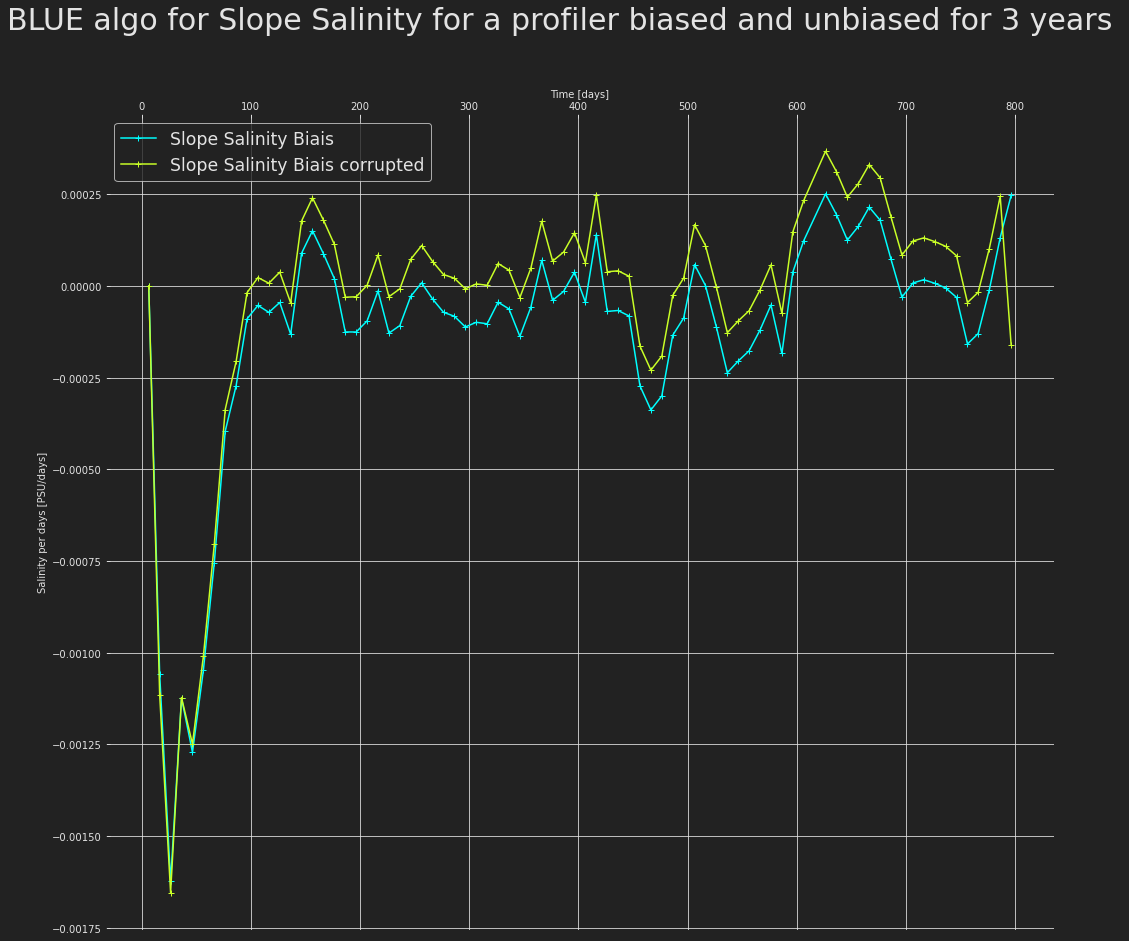

In [116]:
Kalman_ARGOs2(30,ds1,10,3,0.00011)